# Visualization

This notebook contains the code for visualizing the results of the experiments.

## Utility functions

In [1]:
import json
import os

def load_json(idx: int, seed: int = 42, what: str = "runhistory") -> dict:
    path = f"../benchmark-results/autoibc-{idx}/{seed}/{what}.json"
    if not os.path.exists(path):
        return None
    with open(path) as f:
        return json.load(f)
    
def load_runhistory(idx: int, seed: int = 42) -> list[dict] | None:
    runhistory = load_json(idx, seed, "runhistory")
    if runhistory is None:
        return None
    data = runhistory["data"]
    fields = ["config_id", "instance_id", "seed", "budget", "cost", "time", "status", "starttime", "endtime", "additional_info"]
    return [dict(zip(fields, values)) for values in data]

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

ALL_DATA_IDS = [976, 980, 1002, 1018, 1019, 1021, 1040, 1053, 1116, 41160]
EVAL_SCORING = "balanced_accuracy"
SEED = 3009
SAVE = False

In [3]:
BASELINES = {idx: load_json(idx, seed=SEED, what="results")["baseline"] for idx in ALL_DATA_IDS}

# Run History

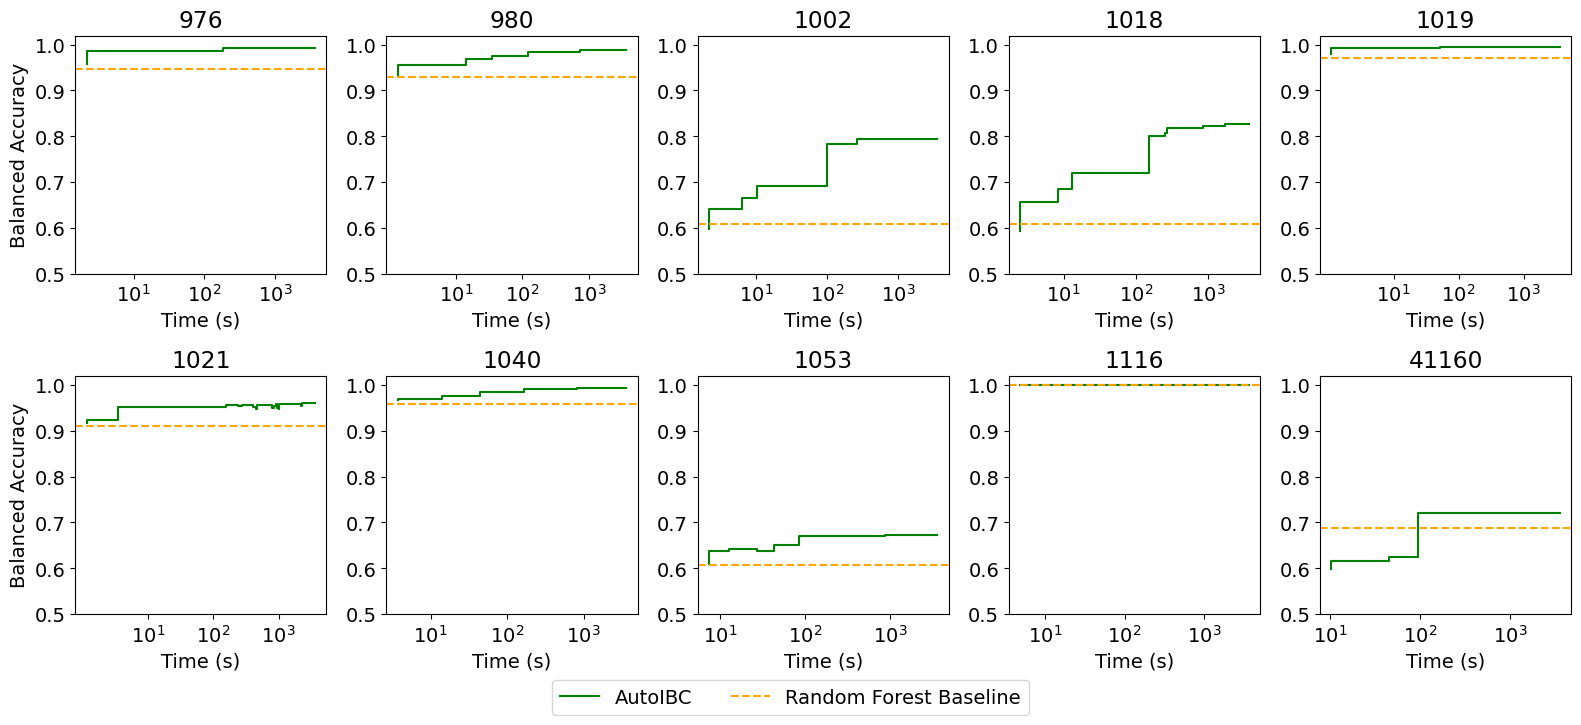

In [5]:
from matplotlib import pyplot as plt
import numpy as np


fig = plt.figure(figsize=(16, 7))

for i, idx in enumerate(ALL_DATA_IDS, start=1):
    ax = fig.add_subplot(2, 5, i)

    intensifier = load_json(idx, seed=SEED, what="intensifier")
    if not intensifier:
        print(f"Skipping {idx}")
        continue
    trajectory = intensifier["trajectory"]

    timestamps = [np.log10(run["walltime"]) for run in trajectory]
    scores = [-run["costs"][0] for run in trajectory]
    trials = [run["trial"] for run in trajectory]

    timestamps.append(np.log10(3600))
    scores.append(scores[-1])

    ax.step(timestamps, scores, label=f"{idx}", color="green") #, marker="o", where="post")
    ax.axhline(y = BASELINES[idx], color = 'orange', linestyle = '--', label="Baseline")

    ax.set_title(f"{idx}")
    ax.set_xlabel("Time (s)")
    timesteps = [1, 2, 3]
    ax.set_xticks(timesteps)
    ax.set_xticklabels([fr"$10^{t}$" for t in timesteps])
    if i in [1, 6]:
        ax.set_ylabel("Balanced Accuracy")
    ax.set_ylim(0.5, 1.02)
    # ax.set_xlim(0, 3600)

plt.figlegend(['AutoIBC', 'Random Forest Baseline'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
fig.tight_layout(pad=1.0)

if SAVE:
    fig.savefig("figures/run-history.pdf", bbox_inches='tight')
    fig.savefig("../../auto-ibc-report/figures/run-history.pdf", bbox_inches='tight')

# Budgets

We compare the balanced accuracy across budgets. Each point represents a single configuration.
Both axes represent the balanced accuracy score.

/Users/fstermann/dev/autoibc/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


976       980       1002      1018      1019      1021    
0.1125 0.225  0.878660  0.527733  0.916179  0.906273  0.690735  0.894051  \
       0.45   0.774538  0.149405  0.924839  0.893328  0.184650  0.646868   
       0.9    0.810114 -0.652372  0.816305  0.902941  0.150098  0.581360   
0.225  0.45   0.913974  0.607532  0.911240  0.947482  0.735339  0.802438   
       0.9    0.770627 -0.129116  0.820592  0.931085  0.623758  0.761116   
0.45   0.9    0.901921  0.559102  0.901658  0.962875  0.890846  0.582759   
All           0.823465  0.605425  0.898171  0.937127  0.658303  0.613372   

                 1040      1053      1116      41160  
0.1125 0.225 -0.054135  0.961138  0.643540  0.952381  
       0.45   0.272727  0.885217  0.480747  1.000000  
       0.9   -0.700000  0.230769       NaN  1.000000  
0.225  0.45   0.789474  0.951042  0.705774  0.833333  
       0.9   -0.500000  0.457391       NaN  0.400000  
0.45   0.9    0.412088  0.798880  0.675303  0.828571  
All           0.591766  0.848441  0.601195  0.778758

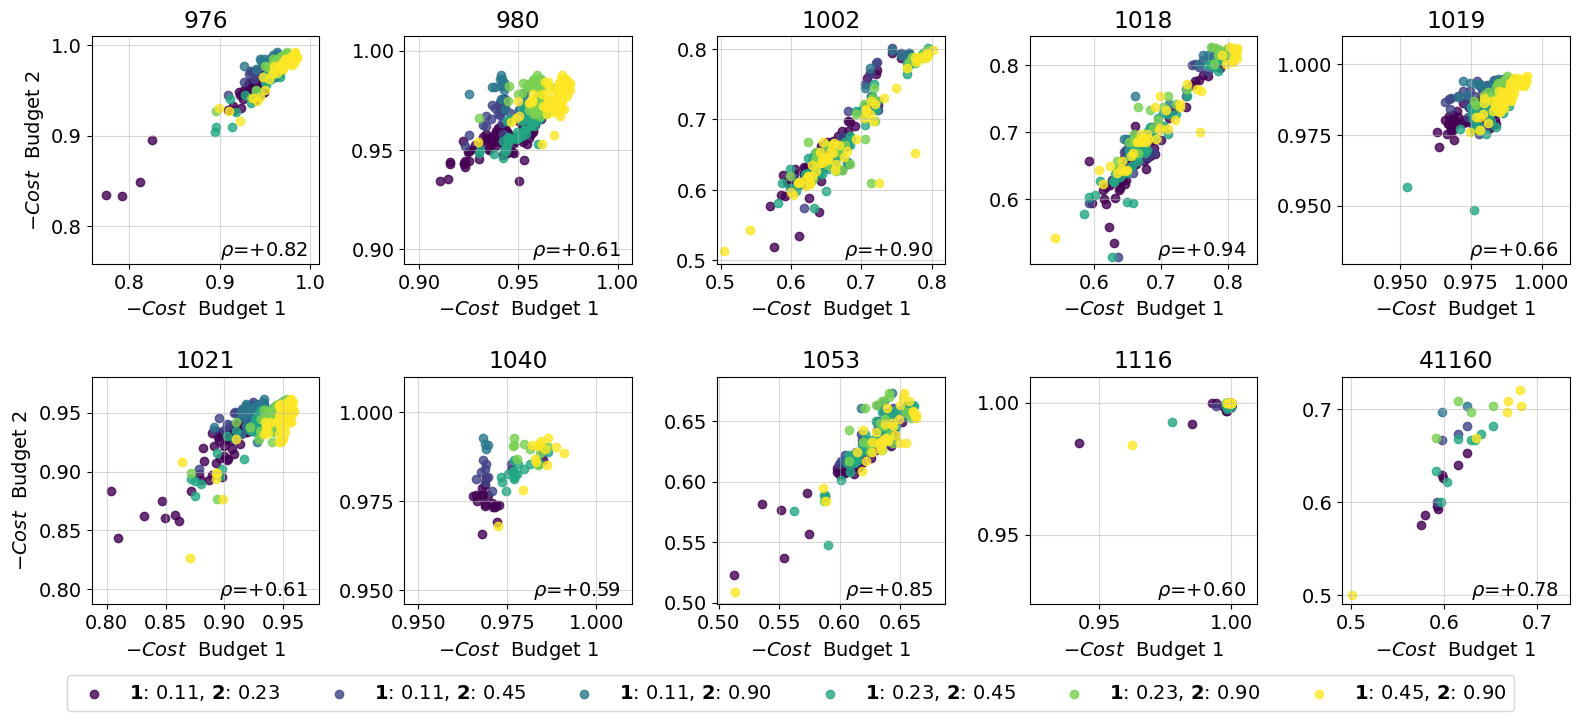

In [7]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm
from scipy import stats

fig = plt.figure(figsize=(16, 7))

correlations = {}

for i, idx in enumerate(ALL_DATA_IDS, start=1):
    ax = fig.add_subplot(2, 5, i)
    runhistory = load_runhistory(idx, seed=SEED)
    if not runhistory:
        print(f"Skipping {idx}")
        continue
    budgets = sorted(set(run["budget"] for run in runhistory))
    budget_combinations = list(itertools.combinations(budgets, 2))

    extremes = (1, 0)
    colors = matplotlib.cm.viridis(np.linspace(0, 1, len(budget_combinations)))
    corrs = {}
    all_scores = {1: [], 2: []}

    for j, (budget1, budget2) in enumerate(budget_combinations):
        runs1 = {run["config_id"]: run for run in runhistory if run["budget"] == budget1}
        runs2 = {run["config_id"]: run for run in runhistory if run["budget"] == budget2}

        common_configs =set.intersection(set(runs1), set(runs2))
        scores1 = [-runs1[config]["cost"] for config in common_configs]
        scores2 = [-runs2[config]["cost"] for config in common_configs]
        all_scores[1].extend(scores1)
        all_scores[2].extend(scores2)

        # corr = np.corrcoef(scores1, scores2)[0, 1]
        corr = stats.spearmanr(scores1, scores2).statistic
        corrs[(budget1, budget2)] = corr
        label = fr"$\rho$={corr:+.2f}"
        ax.scatter(scores1, scores2, alpha=0.8, label=label, color=colors[j])

        extremes = (min(extremes[0], min(scores1 + scores2)), max(extremes[1], max(scores1 + scores2)))
    

    # all_corr = np.corrcoef(all_scores[1], all_scores[2])[0, 1]
    all_corr = stats.spearmanr(all_scores[1], all_scores[2]).statistic
    ax.text(0.95, 0.01, fr"$\rho$={all_corr:+.2f}", fontsize=14, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='right')

    corrs[("All", "")] = all_corr
    correlations[idx] = corrs

    ax.set_title(f"{idx}")
    margin = extremes[1] - extremes[0]
    tick_steps = {
        margin > 0.05: 0.05,
        margin > 0.2: 0.1,
    }.get(True, 0.025)
    loc = matplotlib.ticker.MultipleLocator(base=tick_steps) 
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlabel("$-Cost\ $ Budget 1")
    if i in [1, 6]:
        ax.set_ylabel("$-Cost\ $ Budget 2")
    ax.set_xlim(extremes[0] * 0.98, min(extremes[1] * 1.02, 1.01))
    ax.set_ylim(extremes[0] * 0.98, min(extremes[1] * 1.02, 1.01))

    #Grid
    ax.grid(which='both', alpha=0.5)
    ax.set_aspect('equal', 'box')


# Set legend
labels = [f"$\mathbf{{1}}$: {budget1:.2f}, $\mathbf{{2}}$: {budget2:.2f}" for budget1, budget2 in budget_combinations]
plt.figlegend(labels, loc = 'lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))
fig.tight_layout(pad=1.0)
if SAVE:
    fig.savefig("figures/budget_correlations.pdf", bbox_inches='tight')
    fig.savefig("../../auto-ibc-report/figures/budget_correlations.pdf", bbox_inches='tight')

# Show correlations as table, too crowded in plot
pd.DataFrame(correlations)


# Runtime

,976,980,1002,1018,1019,1021,1040,1053,1116,41160
Budget 0.1125,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Budget 0.225,2.33,1.39,1.94,1.99,1.48,1.82,2.10,2.39,2.18,2.26
Budget 0.45,5.30,3.17,4.51,4.34,3.53,3.62,6.98,4.92,5.82,4.26
Budget 0.9,9.47,5.72,7.39,7.93,8.04,7.12,16.29,8.80,12.97,10.77


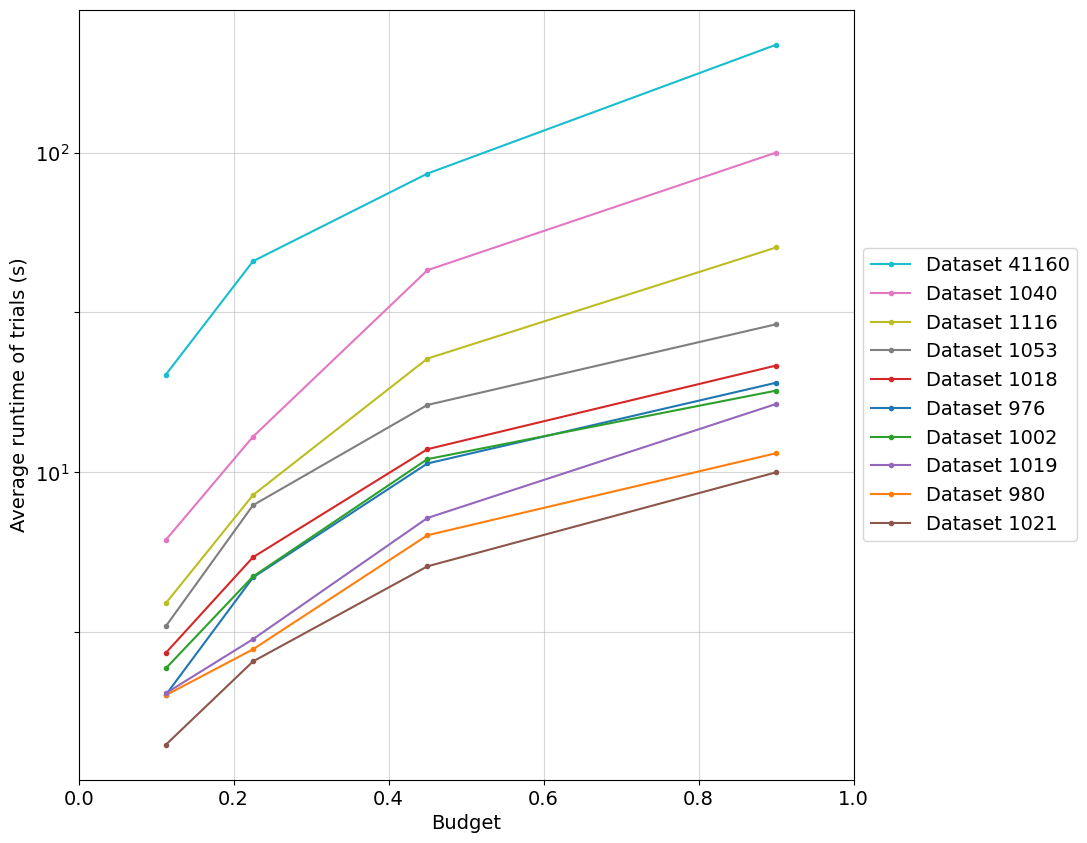

In [151]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

results = {}

for i, idx in enumerate(ALL_DATA_IDS, start=1):
    runhistory = load_runhistory(idx, seed=SEED)
    if not runhistory:
        print(f"Skipping {idx}")
        continue
    budgets = sorted(set(run["budget"] for run in runhistory))

    avg_runtimes, increase = [], {}
    for budget in budgets:
        runs = [run for run in runhistory if run["budget"] == budget]
        runtimes = [run["time"] for run in runs]
        # log_runtimes = [np.log10(run["time"]) for run in runs]
        avg_runtimes.append(np.mean(runtimes))
        increase[f"Budget {budget}"] = f"{(np.mean(runtimes) / avg_runtimes[0]):.2f}"

    avg_log_runtimes = [np.log10(runtime) for runtime in avg_runtimes]
    ax.plot(budgets, avg_log_runtimes, label=f"Dataset {idx}", marker=".")
    results[idx] = increase

ax.set_xlabel("Budget")
ax.set_ylabel("Average runtime of trials (s)")
ax.set_xlim(0, 1)
timesteps = [0.5, 1, 1.5, 2]
ax.set_yticks(timesteps)
ax.set_yticklabels([fr"$10^{{{t}}}$" if int(t) == t else "" for t in timesteps])

ax.grid(which='both', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by values
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -t[1].get_ydata()[-1]))
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

if SAVE:
    fig.savefig("figures/runtime.pdf", bbox_inches='tight')
    fig.savefig("../../auto-ibc-report/figures/runtime.pdf", bbox_inches='tight')

pd.DataFrame(results)

# Configuration Space

In [152]:
import pandas as pd

configspace = load_json(976, seed=SEED, what="configspace")
df = pd.DataFrame(configspace["hyperparameters"])

# Preparing new columns
df.insert(0, "step", "")
df.insert(1, "component", df["name"].str.split(":").str[0])
df.insert(2, "parameter", df["name"].str.split(":").str[1])
df.drop(columns=["name"], inplace=True)

# Splitting into steps
comps = df.loc[~df["component"].str.startswith("Auto"),]
mapping = {choice: row.component for row in comps.itertuples() for choice in row.choices}
df["step"] = df["component"].apply(mapping.get)

# Fill unfilled values
df.fillna("-", inplace=True)

# Format names
df["step"] = pd.Categorical(df["step"], ["-", "imputation", "scaling", "sampling", "classification"])
df.sort_values(by=["step", "component", "parameter"], inplace=True)
df.columns = df.columns.str.capitalize()

df

,Step,Component,Parameter,Type,Choices,Default,Weights,Log,Lower,Upper
0,-,classification,-,categorical,"[AutoRandomForest, AutoGradientBoosting, AutoSGD]",AutoRandomForest,"[1, 1, 1]",-,-,-
1,-,imputation,-,categorical,"[AutoSimpleImputer, AutoKNNImputer]",AutoSimpleImputer,"[1, 1]",-,-,-
2,-,sampling,-,categorical,"[AutoSMOTE, AutoSMOTEENN, AutoSMOTETomek]",AutoSMOTE,"[1, 1, 1]",-,-,-
3,-,scaling,-,categorical,"[AutoStandardScaler, None]",AutoStandardScaler,"[1, 1]",-,-,-
10,imputation,AutoKNNImputer,n_neighbors,uniform_int,-,5,-,False,1.0,25.0
32,imputation,AutoSimpleImputer,strategy,categorical,"[mean, median, most_frequent]",mean,-,-,-,-
33,scaling,AutoStandardScaler,with_mean,categorical,"[True, False]",True,-,-,-,-
34,scaling,AutoStandardScaler,with_std,categorical,"[True, False]",True,-,-,-,-
28,sampling,AutoSMOTE,k_neighbors,uniform_int,-,5,-,False,1.0,25.0
29,sampling,AutoSMOTEENN,k_neighbors,uniform_int,-,5,-,False,1.0,25.0


# Best Incumbents

In [153]:
all_configs = {}
STEPS = ["imputation", "scaling", "sampling", "classification"]

for idx in ALL_DATA_IDS:
    config = load_json(idx, seed=SEED, what="runhistory")
    if not config:
        print(f"Skipping {idx}")
        continue
    config = config["configs"]
    intensifier = load_json(idx, seed=SEED, what="intensifier")
    results = load_json(idx, seed=SEED, what="results")
    best_config_id = intensifier["incumbent_ids"][0]
    best_config = config[str(best_config_id)]
    print()
    all_configs[idx] = {k: v for k, v in best_config.items() if k in STEPS}
    sampler = all_configs[idx]["sampling"]
    all_configs[idx]["balanced accuracy"] = f"{results['autoibc']:.4f}"
    all_configs[idx]["baseline"] = f"{results['baseline']:.4f}"
    all_configs[idx]["difference"] = f"{(results['autoibc'] - results['baseline']):+.4f}"

df = pd.DataFrame(all_configs).T
df = df[STEPS+["balanced accuracy", "baseline", "difference"]]
df.columns = df.columns.str.title()
df

,Imputation,Scaling,Sampling,Classification,Balanced Accuracy,Baseline,Difference
976,AutoKNNImputer,AutoStandardScaler,AutoSMOTETomek,AutoGradientBoosting,0.9911,0.9477,+0.0434
980,AutoKNNImputer,None,AutoSMOTE,AutoGradientBoosting,0.9812,0.9298,+0.0514
1002,AutoKNNImputer,AutoStandardScaler,AutoSMOTETomek,AutoSGD,0.8014,0.6081,+0.1933
1018,AutoSimpleImputer,AutoStandardScaler,AutoSMOTE,AutoSGD,0.8138,0.6082,+0.2055
1019,AutoSimpleImputer,None,AutoSMOTETomek,AutoGradientBoosting,0.9964,0.9700,+0.0264
1021,AutoSimpleImputer,AutoStandardScaler,AutoSMOTETomek,AutoRandomForest,0.9612,0.9096,+0.0516
1040,AutoKNNImputer,AutoStandardScaler,AutoSMOTETomek,AutoGradientBoosting,0.9925,0.9586,+0.0338
1053,AutoKNNImputer,None,AutoSMOTETomek,AutoRandomForest,0.6631,0.6066,+0.0565
1116,AutoSimpleImputer,AutoStandardScaler,AutoSMOTETomek,AutoRandomForest,1.0000,1.0000,+0.0000
41160,AutoSimpleImputer,None,AutoSMOTETomek,AutoRandomForest,0.7126,0.6881,+0.0245
